# Proyecto de detección de anomalías  v1

- Red Neuronal Convolucional que implementa procesamiento de imagenes usando tomografías de pecho para detectar síntomas de neumonía y tumores pulmonares.

> Este repositorio no incluye el data set, pues es muy pesado. Aqui puedes encontrar el [dataset de radiografias](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia), descargalo y agregalo al folder.

Importaciones necesarias para el modelo:


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

# Ver si es posible utilizar los nucleos cuda de los graficos dedicados, si hubiese.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Using device: ', {device})

accuracyArray = []

Using device:  {device(type='cpu')}


In [2]:
switch = int(input('Are you in the Mac or in the PC? Use 1 to indicate you are using Mac', ))

if switch == 1:
    
    trainPath = '/Users/fervargas/Developer/py/cnn/chest_xray/train'
    testPath = '/Users/fervargas/Developer/py/cnn/chest_xray/test'
    ValidationPath = '/Users/fervargas/Developer/py/cnn/chest_xray/val' 
else:
    trainPath = "C:/Users/fvarg/Developer/py/pulmonAID/chest_xray/train"
    testPath = "C:/Users/fvarg/Developer/py/pulmonAID/chest_xray/test"
    ValidationPath = "C:/Users/fvarg/Developer/py/pulmonAID/chest_xray/val"
transform = transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])


In [3]:

# Crear data sets para los entrenamientos, la validacion y las pruebas
trainDS = datasets.ImageFolder(trainPath, transform=transform)
valDS = datasets.ImageFolder(ValidationPath, transform=transform)
testDS = datasets.ImageFolder(testPath, transform=transform)

Asignar el numero de elementos que se analizaran a la vez (batch) y crear los loaders (objetos que posteriormente se convertira en el modelo)

In [4]:
batchSize = 64

trainLoader = DataLoader(dataset=trainDS, batch_size=batchSize, shuffle=True)
valLoader = DataLoader(dataset=valDS, batch_size=batchSize, shuffle=True)
testLoader = DataLoader(dataset=testDS, batch_size=batchSize, shuffle=True)

La imagen representa: PNEUMONIA


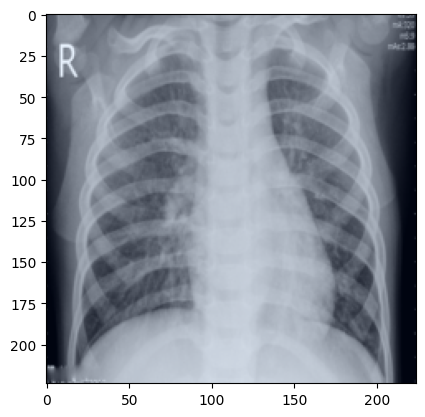

In [5]:
categorias = ['NORMAL', 'PNEUMONIA']

def plot_image(image):
    plt.imshow(image.permute(1,2,0))
    plt.show()

sample_id = np.random.randint(int(len(testDS)))
print(f'La imagen representa: {categorias[testLoader.dataset[sample_id][1]]}')
image = testLoader.dataset[sample_id][0]
image = (image - image.min()) / (image.max() - image.min())
plot_image(image)

In [6]:
def accuracy(model, loader):
    num_correct = 0
    num_total = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for (xi, yi) in loader:
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)
            scores = model(xi) # mb_size, 10
            _, pred = scores.max(dim=1) #pred shape (mb_size )
            num_correct += (pred == yi.squeeze()).sum() # pred shape (mb_size), yi shape (mb_size, 1)
            num_total += pred.size(0)

        return float(num_correct)/num_total     

In [7]:
def train(model, optimiser, epochs=100):
    model = model.to(device=device)
    for epoch in range(epochs):
        for (xi, yi) in trainLoader:
            model.train()
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = lambda x : model(x)
            cost = F.cross_entropy(input= scores(xi), target=yi.squeeze())
        
            optimiser.zero_grad()           
            cost.backward()
            optimiser.step()           
            
        acc = accuracy(model, valLoader)
        if epoch%1 == 0:     
            print(f'Epoch: {epoch}, costo: {cost.item()}, val accuracy: {acc},')

In [8]:
channel1 = 16
channel2 = 32
modelCNN1 = nn.Sequential(
                nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3,
                        padding=1, stride=1, bias=True),
                nn.BatchNorm2d(num_features=32),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size= (2, 2), stride=(2,2)),
            
                nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3,
                        padding=1, stride=1, bias=True),
                nn.BatchNorm2d(num_features=64),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size= (2, 2), stride=(2,2)),
            
                nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3,
                        padding=1, stride=1, bias=True),
                nn.BatchNorm2d(num_features=128),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size= (2, 2), stride=(2,2)),
            
                nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3,
                        padding=1, stride=1, bias=True),
                nn.BatchNorm2d(num_features=128),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size= (2, 2), stride=(2,2)),
            
                nn.Flatten(),
                nn.Linear(in_features = 14*14*128, out_features = 2, bias=True)
            )

In [9]:
epochs = 10
num_classes = 2
# lr = 0.000031
lr = 0.00001
optimizer = optim.Adam(params = modelCNN1.parameters(), lr= lr)
train(modelCNN1, optimizer, epochs)
# acc = accuracy(modelCNN1, valLoader)
acc = accuracy(modelCNN1, testLoader)

Epoch: 0, costo: 0.13771477341651917, accuracy: 0.75,
Epoch: 1, costo: 0.07138734310865402, accuracy: 0.6875,
Epoch: 2, costo: 0.03141290694475174, accuracy: 0.6875,
Epoch: 3, costo: 0.13579010963439941, accuracy: 0.75,
Epoch: 4, costo: 0.05283035337924957, accuracy: 0.75,
Epoch: 5, costo: 0.07736803591251373, accuracy: 0.75,
Epoch: 6, costo: 0.06022317335009575, accuracy: 0.75,
Epoch: 7, costo: 0.03432092070579529, accuracy: 0.75,
Epoch: 8, costo: 0.04149813577532768, accuracy: 0.8125,
Epoch: 9, costo: 0.018563635647296906, accuracy: 0.75,


In [10]:
print(acc)

0.7339743589743589
